# Data Cleaning - Investigating SAT Scores and School Demographics of NYC Public Schools


## Table of Contents

* [SAT Data](#sat)
    * [Detect Missing Data](#sat_missing)
    * [Add Score Ranges Column](#sat_ranges)
    * [Fill Suppressed Data](#sat_fill)
    
* [Demographics Data](#demos)
    * [Filter Out Irrelevant Columns](#demos_filter)
    * [Detect Missing Data](#demos_missing)
    * [Keep Data On Schools Only Present In SAT Data](#demos_keep)

* [Combining the Data](#sat_demos)
    * [Drop Rows Without Demographics Data](#sat_demos_drop_missing)
    * [Add Columns](#sat_demos_add_percent_enrolled)
    * [Drop Irrelevant Columns](#sat_demos_drop)



Data sources:
- [SAT Data](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT Score data for NYC high school seniors graduating that year (2012)
- [NYC School Demographics Data](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j): Demographics data for NYC public schools (most recent data from 2011-12 school year)

#### Imports 

In [397]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

### SAT Data<a class="anchor" id="sat"></a> 

In [437]:
# read the data
sat = pd.read_csv('sat_ny.csv')
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [438]:
#get number of rows
sat_rows = sat.shape[0]
sat_rows

478

In [439]:
#get data types/column names
sat_types = sat.dtypes
sat_types

DBN                                object
SCHOOL NAME                        object
Num of SAT Test Takers             object
SAT Critical Reading Avg. Score    object
SAT Math Avg. Score                object
SAT Writing Avg. Score             object
dtype: object

### Detect whether or not dataset has any missing values<a class="anchor" id="sat_missing"></a> 

In [440]:
#there are no missing values
sat_cols = list(sat.columns)
for c in sat_cols:
    #all data are strings, so strings that start with empty space (' ') will be assumed as empty
    print(c + ': ' + str(sat[c].str.startswith(' ').values.any()))

DBN: False
SCHOOL NAME: False
Num of SAT Test Takers: False
SAT Critical Reading Avg. Score: False
SAT Math Avg. Score: False
SAT Writing Avg. Score: False


In [441]:
# get all the school DBNs (unique identifiers) for the schools in the SAT data
sat_dbns = list(sat['DBN'])
sat_codes = []
for dbn in sat_dbns:
    code = dbn[2:]
    sat_codes.append(code)

<a class="anchor" id="sat_ranges"></a> 
Instead of being listed as null, suppressed data points are marked by 's.' Based on NYC's [2010 Data](https://data.cityofnewyork.us/Education/SAT-College-Board-2010-School-Level-Results/zt9s-n5aj), 's' means there were fewer than 5 test takers. These rows will be left in for now.

SAT Scores are also most commonly expressed as a composite score. I will thus create a new column that adds up the scores from each column. Additionally, I will edit the subject scores to be expressed in ranges that correspond with the [percentiles from 2012](http://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-2012.pdf) as seen below:

Reading
* 90-99th percentile: [650, 800]
* 71st-88th percentile: [560, 640]
* 51st-67th percentile: [500, 550]
* 21st-48th percentile: [410, 490]
* below 20th percentile: [200, 400]

Math
* 90-99th percentile: [680, 800]
* 70-89th percentile: [580, 670]
* 52nd-67th percentile: [520, 570]
* 21st-49th percentile: [420, 510]
* below 20th percentile: [200, 410]

Writing
* 90-99th percentile: [650, 800]
* 70-89th percentile: [550, 640]
* 52nd-67th percentile: [490, 540]
* 21st-48th percentile: [400, 480]
* below 20th percentile: [200, 390]

Composite
* 90-99th percentile: [1930, 2400]
* 70-89th percentile: [1670, 1920]
* 50-69th percentile: [1490, 1660]
* 20-49th percentile: [1230, 1480]
* below 20th percentile: [600, 1220]

In [442]:
#functions to replace average scores with score ranges as shown above
def r_range(r):
    if 650 <= r <= 800:
        return '650-800'
    elif 560 <= r <= 649:
        return '560-640'
    elif 500 <= r <= 559:
        return '500-550'
    elif 410 <= r <= 499:
        return '410-490'
    else:
        return '200-400'
def m_range(m):
    if 680 <= m <= 800:
        return '680-800'
    elif 580 <= m <= 679:
        return '580-670'
    elif 520 <= m <= 579:
        return '520-570'
    elif 420 <= m <= 519:
        return '420-510'
    else:
        return '200-410'
def w_range(w):
    if 650 <= w <= 800:
        return '650-800'
    elif 550 <= w <= 649:
        return '550-640'
    elif 490 <= w <= 549:
        return '490-550'
    elif 400 <= w <= 489:
        return '400-480'
    else:
        return '200-390'
def c_range(c):
    if 1930 <= c <= 2400:
        return '1930-2400'
    elif 1670 <= c <= 1929:
        return '1670-1920'
    elif 1490 <= c <= 1669:
        return '1490-1660'
    elif 1230 <= c <= 1489:
        return '1230-1480'
    else:
        return '600-1220'

In [443]:
#create lists of score ranges (str), raw composite scores (int)
composites = []
composites_raw = []
r_ranges = []
m_ranges = []
w_ranges = []
for i, row in sat.iterrows():
    n = row['Num of SAT Test Takers']
    #do not change suppressed data
    if n == 's':
        composites.append('s')
        r_ranges.append('s')
        m_ranges.append('s')
        w_ranges.append('s')
        composites_raw.append('s')
        continue
    r = int(row['SAT Critical Reading Avg. Score'])
    m = int(row['SAT Math Avg. Score'])
    w = int(row['SAT Writing Avg. Score'])
    c = int(r+m+w)
    composites_raw.append(c)
    composites.append(c_range(c))
    r_ranges.append(r_range(r))
    m_ranges.append(m_range(m))
    w_ranges.append(w_range(w))

In [444]:
#drop old score columns
sat = sat.drop(columns=['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score'])

In [445]:
#replace dropped columns with the score ranges
sat.insert(3, 'SAT Composite Avg. Score', composites)
sat.insert(4, 'SAT Critical Reading Avg. Score', r_ranges)
sat.insert(5, 'SAT Math Avg. Score', m_ranges)
sat.insert(6, 'SAT Writing Avg. Score', w_ranges)
sat.insert(7, 'SAT Composite Avg. Raw Score', composites_raw)
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Composite Avg. Score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT Composite Avg. Raw Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,600-1220,200-400,200-410,200-390,1122
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,600-1220,200-400,420-510,200-390,1172
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,600-1220,200-400,200-410,200-390,1149
3,01M458,FORSYTH SATELLITE ACADEMY,7,600-1220,410-490,200-410,200-390,1174
4,01M509,MARTA VALLE HIGH SCHOOL,44,600-1220,200-400,420-510,200-390,1207


<a class="anchor" id="sat_fill"></a>Since distribution is skewed right, I will use the median to fill in the suppressed data points

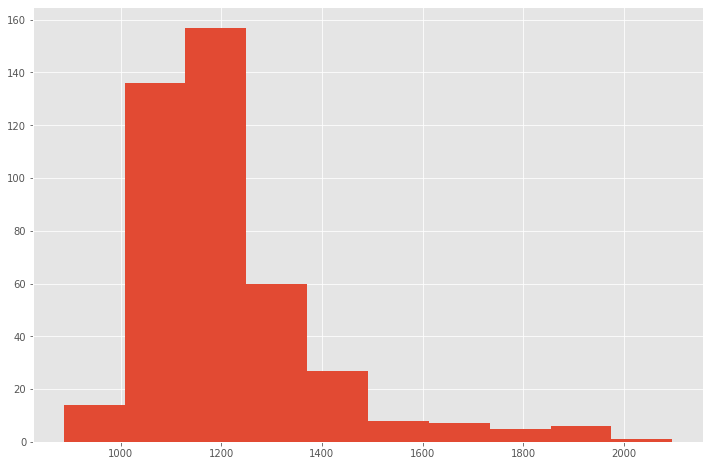

In [446]:
#draw histogram of all raw score averages
sat_raw_ints = list(filter(lambda x: type(x) == int, list(sat['SAT Composite Avg. Raw Score'])))
plt.hist(sat_raw_ints)
plt.show()

In [447]:
sat_raw_median = np.median(sat_raw_ints)
sat['SAT Composite Avg. Raw Score'] = sat['SAT Composite Avg. Raw Score'].replace('s', sat_raw_median)

In [448]:
#save to csv
sat.to_csv('sat_cleaned.csv', index=False)

### Demographics Data<a class="anchor" id="demos"></a> 

In [423]:
demos = pd.read_csv('demographics_ny.csv')
demos.head(6)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4
5,01M015,P.S. 015 ROBERTO CLEMENTE,20102011,,96.5,203,13,37,35,33,...,75,36.9,110,54.2,4,2.0,113.0,55.7,90.0,44.3


In [424]:
demos.shape[0]

10075

<a class="anchor" id="demos_filter"></a>Notes on the columns:
* **fl_percent** is percent of students who speak foreign language (presumably percent of students who speak English as a second language)
* **frl_percent** is percent of students under the National School Lunch Program. These students receive free or reduced-price lunches and are from low income households.
* **sped_num** and **sped_percent** are measures of how many special ed students there are

I will focus on columns that reveal information about students' ethnicity, socioeconomic situation, and gender. All other columns will thus be removed. Additionally, I will only focus on the most recent school years (2011-2012).

In [425]:
#get original columns 
demos_cols_og = list(demos.columns)
#get the columns detailing enrollment by grade level
grades = demos_cols_og[6:20]

In [426]:
#drop grade columns
demos = demos.drop(columns=grades)
#drop other unrelated columns
demos = demos.drop(columns=['fl_percent', 'ctt_num', 'selfcontained_num'])
demos.head()

,DBN,Name,schoolyear,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,NaN,281,36.0,12.8,57.0,20.3,10,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,NaN,243,38.0,15.6,55.0,22.6,18,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,NaN,261,52.0,19.9,60.0,23.0,16,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,NaN,252,48.0,19.0,62.0,24.6,16,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,96.5,208,40.0,19.2,46.0,22.1,16,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [427]:
#get data types of each column
demos_types = demos.dtypes
demos_types

DBN                  object
Name                 object
schoolyear            int64
frl_percent         float64
total_enrollment      int64
ell_num             float64
ell_percent         float64
sped_num            float64
sped_percent        float64
asian_num             int64
asian_per           float64
black_num             int64
black_per           float64
hispanic_num          int64
hispanic_per        float64
white_num             int64
white_per           float64
male_num            float64
male_per            float64
female_num          float64
female_per          float64
dtype: object

In [428]:
#keep only 20112012 data
demos = demos.loc[demos['schoolyear'] == 20112012]
demos = demos.drop(columns=['schoolyear'])
demos.head()

,DBN,Name,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,89.4,189,20.0,10.6,40.0,21.2,12,6.3,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,61.5,328,33.0,10.1,59.0,18.0,51,15.5,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,92.5,626,128.0,20.4,97.0,15.5,190,30.4,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,99.7,401,34.0,8.5,106.0,26.4,22,5.5,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,78.9,176,6.0,3.4,45.0,25.6,9,5.1,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


#### Detect and Handle Missing Data<a class="anchor" id="demos_missing"></a>

In [429]:
demos_cols = list(demos.columns)
for c in demos_cols:
    if (demos[c].dtype == int) or (demos[c].dtype == float):
        print(c + ': ' + str(demos[c].isnull().values.any()))
    else:
        #all other data types are strings
        print(c + ': ' + str(demos[c].str.startswith(' ').values.any()))

DBN: False
Name: False
frl_percent: False
total_enrollment: False
ell_num: False
ell_percent: False
sped_num: False
sped_percent: False
asian_num: False
asian_per: False
black_num: False
black_per: False
hispanic_num: False
hispanic_per: False
white_num: False
white_per: False
male_num: False
male_per: False
female_num: False
female_per: False


Since no null values were detected for the information expressed in both percentages and numbers, I will only keep the percentage columns

In [430]:
demos = demos.drop(columns=list(filter(lambda c: 'num' in c, demos_cols)))
demos = demos.reset_index(drop=True)
demos.head()

,DBN,Name,frl_percent,total_enrollment,ell_percent,sped_percent,asian_per,black_per,hispanic_per,white_per,male_per,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,89.4,189,10.6,21.2,6.3,33.3,57.7,2.1,51.3,48.7
1,01M019,P.S. 019 ASHER LEVY,61.5,328,10.1,18.0,15.5,24.7,48.2,8.5,44.8,55.2
2,01M020,PS 020 ANNA SILVER,92.5,626,20.4,15.5,30.4,8.8,57.0,2.6,52.7,47.3
3,01M034,PS 034 FRANKLIN D ROOSEVELT,99.7,401,8.5,26.4,5.5,22.4,68.6,2.0,50.9,49.1
4,01M063,PS 063 WILLIAM MCKINLEY,78.9,176,3.4,25.6,5.1,23.3,62.5,8.5,55.1,44.9


<a class="anchor" id="demos_keep"></a>Remove rows for schools not present in the SAT data

In [431]:
for i, row in demos.iterrows():
    dbn = row['DBN']
    if dbn not in sat_dbns:
        demos = demos.drop(index = i)
demos = demos.reset_index(drop=True)
demos.head()

,DBN,Name,frl_percent,total_enrollment,ell_percent,sped_percent,asian_per,black_per,hispanic_per,white_per,male_per,female_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,88.6,422,22.3,24.9,14.0,29.1,53.8,1.7,61.4,38.6
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,71.8,394,21.1,21.8,29.2,22.6,45.9,2.3,57.4,42.6
2,01M450,EAST SIDE COMMUNITY HIGH SCHOOL,71.8,598,5.0,26.4,9.7,23.9,55.4,10.4,54.7,45.3
3,01M458,SATELLITE ACADEMY HS @ FORSYTHE STREET,72.8,224,4.0,8.9,2.2,34.4,59.4,3.6,43.3,56.7
4,01M509,MARTA VALLE SECONDARY SCHOOL,80.7,367,11.2,25.9,9.3,31.6,56.9,1.6,46.3,53.7


In [432]:
#ensure there is no missing data
demos_cols = list(demos.columns)
for c in demos_cols:
    if (demos[c].dtype == int) or (demos[c].dtype == float):
        print(c + ': ' + str(demos[c].isnull().values.any()))
    else:
        #all other data types are strings
        print(c + ': ' + str(demos[c].str.startswith(' ').values.any()))

DBN: False
Name: False
frl_percent: False
total_enrollment: False
ell_percent: False
sped_percent: False
asian_per: False
black_per: False
hispanic_per: False
white_per: False
male_per: False
female_per: False


In [433]:
demos.to_csv('demos_cleaned.csv', index=False)

In [434]:
demos.head()

,DBN,Name,frl_percent,total_enrollment,ell_percent,sped_percent,asian_per,black_per,hispanic_per,white_per,male_per,female_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,88.6,422,22.3,24.9,14.0,29.1,53.8,1.7,61.4,38.6
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,71.8,394,21.1,21.8,29.2,22.6,45.9,2.3,57.4,42.6
2,01M450,EAST SIDE COMMUNITY HIGH SCHOOL,71.8,598,5.0,26.4,9.7,23.9,55.4,10.4,54.7,45.3
3,01M458,SATELLITE ACADEMY HS @ FORSYTHE STREET,72.8,224,4.0,8.9,2.2,34.4,59.4,3.6,43.3,56.7
4,01M509,MARTA VALLE SECONDARY SCHOOL,80.7,367,11.2,25.9,9.3,31.6,56.9,1.6,46.3,53.7


## Combining the Data<a class="anchor" id="sat_demos"></a>  

In [449]:
#use the DBN (unique identifier) of the SAT data and demographics data to merge the data
sat_demos = pd.merge(sat, demos, on='DBN', how='outer')
sat_demos = sat_demos.drop(columns=['Name'])
sat_demos.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Composite Avg. Score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT Composite Avg. Raw Score,frl_percent,total_enrollment,ell_percent,sped_percent,asian_per,black_per,hispanic_per,white_per,male_per,female_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,600-1220,200-400,200-410,200-390,1122.0,88.6,422.0,22.3,24.9,14.0,29.1,53.8,1.7,61.4,38.6
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,600-1220,200-400,420-510,200-390,1172.0,71.8,394.0,21.1,21.8,29.2,22.6,45.9,2.3,57.4,42.6
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,600-1220,200-400,200-410,200-390,1149.0,71.8,598.0,5.0,26.4,9.7,23.9,55.4,10.4,54.7,45.3
3,01M458,FORSYTH SATELLITE ACADEMY,7,600-1220,410-490,200-410,200-390,1174.0,72.8,224.0,4.0,8.9,2.2,34.4,59.4,3.6,43.3,56.7
4,01M509,MARTA VALLE HIGH SCHOOL,44,600-1220,200-400,420-510,200-390,1207.0,80.7,367.0,11.2,25.9,9.3,31.6,56.9,1.6,46.3,53.7


In [450]:
sat_demos_rows = sat_demos.shape[0]
sat_rows = sat.shape[0]
demos_rows = demos.shape[0]
sat_rows, demos_rows, sat_demos_rows

(478, 450, 478)

<a class="anchor" id="sat_demos_drop_missing"></a>Schools with suppressed SAT data can demonstrate something valuable. But, if any school's demographics data is missing, we cannot perform the analysis necessary. Thus, all rows with missing demographic data will be dropped

In [451]:
dem_titles = demos_cols[2:]

In [452]:
for i, row in sat_demos.iterrows():
    dems = []
    for c in dem_titles:
        dems.append(np.isnan(row[c]))
    if all(dems):
        sat_demos = sat_demos.drop(index = i)

<a class="anchor" id="sat_demos_add_percent_enrolled"></a>To streamline analysis, a column storing percentage of students enrolled who took the SAT will replace the 'Num of SAT Test Takers' and 'total_enrollment' columns. The percentage is calculated by dividing the figures in 'Num of SAT Test Takers' by those in 'total_enrollment.' For rows that have supressed SAT data, 0 will be inputted

In [453]:
percent_takers = []
for i, row in sat_demos.iterrows():
    n = row['Num of SAT Test Takers']
    enrolled = row['total_enrollment']
    if n == 's':
        percent_takers.append(0)
        continue
    percent = round((int(n) / enrolled) * 100, 1)
    percent_takers.append(percent)

In [454]:
sat_demos = sat_demos.drop(columns=['Num of SAT Test Takers', 'total_enrollment'])
sat_demos.insert(2, 'Percent of Students Enrolled Who Took SAT', percent_takers)

<a class="anchor" id="sat_demos_drop"></a>For this analysis, I will be primarily looking at socioeconmic and ethnic figures. Thus, the demographics data not relating to these figures will be dropped.

In [455]:
sat_demos = sat_demos.drop(columns=['male_per','female_per','sped_percent','ell_percent'])

In [456]:
sat_demos.to_csv('sat_demos_cleaned.csv', index=False)